# Face Reconition usnig Covolutional Neural Network.
### A new way of exploring the doimain using Transfer Learning   

## Mounting Google Drive and Environment Setup


*   The notebook is runs on Google Colab, which is a Cloud Service to execute python scripts.
*   Google Colab provisions a Virtual Machine which upon which Google Drive is mounted as a file server.
*   Google Drive provides multiple types of Hardware accelarators for fast execution of out scripts, which includes CPU, GPU and TPU
*   This Notebook uses a Graphical Processing Unit(GPU) 
*   All the Python Scripts and the data are stored in the Google Drive.





In [ ]:
# Mounting Google Drive
from google.colab import drive
from os.path import join
ROOT = '/content/drive'
print(ROOT)
drive.mount(ROOT)

/content/drive
Mounted at /content/drive


In [ ]:
%cd /content

/content


## Setting up Environment variables and Paths which are to be used by the Machine Learning model.

In [1]:
holly_face_path = '/content/drive/My Drive/Colab Notebooks/ProjectData/FaceRecognition/archive.zip'


face_path = '/content/drive/My Drive/Colab Notebooks/ProjectData/FaceRecognition/dataset2/'

VM_path = '/content'
drive_path = '/content/drive/MyDrive/Colab Notebooks/ProjectData/FaceRecognition/'
VM_face_path = '/content/dataset2'
VM_face_aug_path = '/content/dataset'
face_detection_path= "/content/drive/MyDrive/Colab Notebooks/ProjectData/FaceRecognition/face_detection_model/res10_300x300_ssd_iter_140000.caffemodel"
proto_path = "/content/drive/MyDrive/Colab Notebooks/ProjectData/FaceRecognition/face_detection_model/deploy.prototxt"

## Downloading and unpacking the Dataset from Google Drive to the VM instance

In [2]:
!cp '{holly_face_path}' '/content'

In [3]:
!unzip -q /content/archive.zip -d /content

In [4]:
#!cp -r '{face_path}' '{VM_path}'

In [5]:
#run this if you want to save augmented images
!mkdir /content/dataset

In [ ]:
# run this to clear all in dataset folder
!rm -r /content/dataset/*

rm: cannot remove '/content/dataset/*': No such file or directory


In [ ]:
# run this if you want to save face roi
!mkdir /content/dataset2

In [ ]:
#run this to clear all in dataset2 folder
!rm -r /content/dataset2/*

rm: cannot remove '/content/dataset2/*': No such file or directory


In [ ]:
%ls /content/dataset/

## Importing Libraries and modules

In [6]:
# Always run this
from keras.layers import Input, Lambda, Dense, Flatten,  GlobalAveragePooling2D, Dropout
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.vgg16 import VGG16 
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential , load_model
import keras
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import os
import cv2
from google.colab.patches import cv2_imshow
import pickle
import random
import tensorflow as tf
from sklearn.model_selection import train_test_split


## Data Pre-Processing and augmentation 
* This section is to be executed if Face needs to be extracted from the dataset images for generating training and testing dataset
* This section should **NOT** be excuted when working with Hollywood Dataset since the dataset is pre-processed and need no augmentation   

In [ ]:
#@title Run this if want to produce augmentations of the dataset
#@markdown What this code does is it produces 5 augmentaions for each image in the dataset and saves it in the VM disk
# run this if do not have the face roi. What this code does is it produces 5 augmentaions for each image in the dataset
datagen = ImageDataGenerator(
    rotation_range = 10,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode='nearest')

image_size = 224
NUMBER_TO_AUGMENT = 5
c = 0
labelConverter = {}
dirpath = face_path
paths = os.listdir(dirpath)
#known_face = []
 
for directory in paths:
    !mkdir '/content/dataset/{directory}'
    labelConverter[directory] = c
    c+=1
print(labelConverter)
for p in paths:
    label = labelConverter[p]
    aug_save_path = VM_face_aug_path+'/'+p
    for p1 in os.listdir(dirpath+'/'+p):
      num_aug = 0
      try:
          path = dirpath+'/'+p+'/'+p1
          img = cv2.imread(path)
          #img = cv2.resize(img,(image_size, image_size))
          img_np = np.asarray(img)
          img_np = np.expand_dims(img_np,0)
          print("Image size = ",img_np.shape)
          it = datagen.flow(img_np, batch_size=1, save_to_dir=aug_save_path, save_prefix='celeb', save_format='png')
          while  num_aug < NUMBER_TO_AUGMENT:
            it.next()
            print(num_aug+1,'th augmenatation of',path)
            num_aug += 1
      except Exception as e:
          print("Error",e)




In [ ]:
#@title This uploads the augmented dataset from VM to drive for futute use
#@markdown Since the above operation of creating augmentations is expensive it is advised to save the augmentations in the Google Drive or some other persistant memory.
# this uploads the augmented dataset from VM to drive
!cp -r '{VM_face_aug_path}' '/content/drive/MyDrive/'

In [ ]:
#@title Run This if you need Face detector CV2 DNN model 
# Run This if you need Face detector
print("Loading face detector.....")
detector = cv2.dnn.readNetFromCaffe(proto_path, face_detection_path)

In [ ]:
#@title Run this if you need Haar Face detector model
# run this if you need Haar Face detector
face_dec = cv2.CascadeClassifier(cv2.data.haarcascades+'haarcascade_frontalface_default.xml')

In [ ]:
#@title Run this if you need CV2 DNN Face detector fucntion
# run this if you need DNN Face detector
def getFace_CV2DNN(image):
  (h,w) = image.shape[:2]
  blob = cv2.dnn.blobFromImage(cv2.resize(image, (300,300)),1.0, (300,300),(104.0, 177.0, 123.0), swapRB= False, crop = False)
  detector.setInput(blob)
  detections = detector.forward()
  max = -1
  fHM = 0
  fWM = 0
  x1 = 0
  x2=0
  y1=0
  y2 = 0
  for i in range(0,detections.shape[2]):
    confidence = detections[0,0,i,2];
    
    if confidence < 0.7:
      continue

    box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
    (startX, startY, endX, endY) = box.astype("int")
    cv2.rectangle(image, (startX, startY), (endX, endY), (0,0,255), 2)
    
    
    fH = endX - startX
    fW = endY - startY
    #print("ggg-",fW,fH)
    if fH < 20 or fW < 20:
      continue
    area = fH*fW
    if max < area:
      max = area
      x1 = startX
      x2 = endX
      y1 = startY
      y2 = endY
  return x1,x2,y1,y2


In [ ]:
#@title Run this if you need Haar Face detector function

# run this if you need Haar Face detector
def getFace_haar(image):
  max = -1
  x1 = 0
  x2=0
  y1=0
  y2 = 0
  faces = face_dec.detectMultiScale(image, 1.3,5)
  for (x,y,w,h) in faces:
    #print(w,h)
    if w < 20 or h <20:
      continue
    area = h*w
    if max < area:
      max = area
      x1 = x
      y1 = y
      x2 = x+w
      y2 = y+h

    return x1, x2, y1, y2
    

In [ ]:
#@title Run this if you want to get Face ROI from augmented images
#@markdown It takes each image from the augmented dataset , extracts the faces and craetes another dataset and stores them in VM disk 
# Run this if you want to get face_roi from augmented images  
#knownface = []
count = 0
k = 1
facelabels = os.listdir(VM_face_aug_path)
for f in facelabels:
  sorc = VM_face_aug_path+'/'+f
  dest = VM_face_path+'/'+f
  os.mkdir(dest)
  img_list = os.listdir(sorc)
  print('Processing ',f, str(k), 'out of ', str(len(facelabels)), 'classes')
  k += 1
  for img in img_list:
    imgPath = sorc+'/'+img
    image = cv2.imread(imgPath)
    #faces = face_dec.detectMultiScale(image)
    print(image.shape)
    cord = getFace_CV2DNN(image)
    if cord == None:
      continue
    x1,x2, y1, y2 = cord
    try:
      image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
      face = image[y1:y2, x1:x2]
      
      savepath = dest+'/'+str(count)+'.png'
      count += 1
      
      cv2.imwrite(savepath, face)
    except Exception as e:
      print('Error: ',e) 

In [ ]:
#@title Run this if ypou want to upload the Face ROI from VM to google drive 
#@markdown Since the above operatio is expensive it is advised to store the Face ROI of the augemented images in a persistent memory like Google Drive
# run this if ypou want to upload the face_roi from VM to google drive 
%cp -r '/content/dataset2' '/content/drive/MyDrive'

In [ ]:
#@title Run this if you want to download the Face  ROI from google drive to VM
#@markdown This code block is used to download the Face ROI which is stored in Google drive to VM disk. This can only be used if the Face Roi is previously stored in the Drive
# run this if you want to download the face_roi from google drive to VM
!cp -r '/content/drive/MyDrive/dataset2' '/content'

## Exploring the Hollywood Dataset and generating training , testing and validation sets

In [7]:
!ls -la /content/105_classes_pins_dataset/

total 1176
drwxr-xr-x 107 root root  4096 May 30 14:41  .
drwxr-xr-x   1 root root  4096 May 30 14:41  ..
drwxr-xr-x   2 root root 12288 May 30 14:41 'pins_Adriana Lima'
drwxr-xr-x   2 root root 16384 May 30 14:41 'pins_Alexandra Daddario'
drwxr-xr-x   2 root root 12288 May 30 14:41 'pins_Alex Lawther'
drwxr-xr-x   2 root root 12288 May 30 14:41 'pins_Alvaro Morte'
drwxr-xr-x   2 root root 16384 May 30 14:41 'pins_alycia dabnem carey'
drwxr-xr-x   2 root root  4096 May 30 14:41 'pins_Amanda Crew'
drwxr-xr-x   2 root root 12288 May 30 14:41 'pins_amber heard'
drwxr-xr-x   2 root root 12288 May 30 14:41 'pins_Andy Samberg'
drwxr-xr-x   2 root root 12288 May 30 14:41 'pins_Anne Hathaway'
drwxr-xr-x   2 root root 12288 May 30 14:41 'pins_Anthony Mackie'
drwxr-xr-x   2 root root 12288 May 30 14:41 'pins_Avril Lavigne'
drwxr-xr-x   2 root root  4096 May 30 14:41 'pins_barack obama'
drwxr-xr-x   2 root root 12288 May 30 14:41 'pins_barbara palvin'
drwxr-xr-x   2 root root  4096 May 30 14:41 '

In [8]:
# set the dataset on which you want to train
train_path1 = '/content/105_classes_pins_dataset/'
train_path = '/content/dataset'

### Takes 20 classes from 105_classes_pins_dataset and saves it a new folder /content/dataset

In [9]:
 
count = 0
NB_CLASS = 20
l = os.listdir(train_path1)
for li in l:
  count += 1
  sor = '"105_classes_pins_dataset/'+li+'"'
  dest = 'dataset'
  cmd = 'cp -r '+ sor+' '+ dest
  cmd1 = 'rm -r'+ sor
  os.system(cmd)
  os.system(cmd1)
  if count >= NB_CLASS:
    break


### There are two ways of processing the dataste. 
*    We can use the Image Data generator to generate augmented images and save it in list.
*    Or we ca take all the images and make a list out of it, without augmentation
##### **Currently Data Augmentation is not used as we are getting satisfactory accuracy without augmentation with this Hollywood dataset.**
##### **ML models can only work on numeric data. That is why the label list generated here has a unique integer assigned to each unique class.The block of code here also generated the mapping from label names to integers.**

In [10]:

knownface = []
labels = []
labelEncoder = {}
count = 0
dir = '/content/dataset/'


In [11]:

'''
datagen = ImageDataGenerator(
    rotation_range = 10,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode='nearest')
NUM_AUG = 1
c = 0
for d in os.listdir(dir):
  labelEncoder[count] = d
  print('Processig for ....',d)
  for k in os.listdir(dir+d):
    image = cv2.imread(dir+d+'/'+k)
    img_np = np.asarray(image)
    img_np = img_np[np.newaxis,:,:,:]

    for im in datagen.flow(img_np, batch_size=1):
      imnp = cv2.resize(im[0], (224,224))
      
      knownface.append(imnp)
      labels.append(count)
      c+=1
      if c >= NUM_AUG:
        break
    c = 0
  count += 1 
'''

"\ndatagen = ImageDataGenerator(\n    rotation_range = 10,\n    width_shift_range = 0.2,\n    height_shift_range = 0.2,\n    zoom_range = 0.2,\n    horizontal_flip = True,\n    fill_mode='nearest')\nNUM_AUG = 1\nc = 0\nfor d in os.listdir(dir):\n  labelEncoder[count] = d\n  print('Processig for ....',d)\n  for k in os.listdir(dir+d):\n    image = cv2.imread(dir+d+'/'+k)\n    img_np = np.asarray(image)\n    img_np = img_np[np.newaxis,:,:,:]\n\n    for im in datagen.flow(img_np, batch_size=1):\n      imnp = cv2.resize(im[0], (224,224))\n      \n      knownface.append(imnp)\n      labels.append(count)\n      c+=1\n      if c >= NUM_AUG:\n        break\n    c = 0\n  count += 1 \n"

In [12]:


for d in os.listdir(dir):
  labelEncoder[count] = d
  print('Processig for ....',d)
  for k in os.listdir(dir+d):
    image = cv2.imread(dir+d+'/'+k)
    #img_np = np.asarray(image)
    imnp = cv2.resize(image, (224,224))
    knownface.append(imnp)
    labels.append(count)
  count += 1 



Processig for .... pins_Miley Cyrus
Processig for .... pins_Emilia Clarke
Processig for .... pins_Rebecca Ferguson
Processig for .... pins_Millie Bobby Brown
Processig for .... pins_grant gustin
Processig for .... pins_Mark Zuckerberg
Processig for .... pins_amber heard
Processig for .... pins_Neil Patrick Harris
Processig for .... pins_Bill Gates
Processig for .... pins_Krysten Ritter
Processig for .... pins_Brenton Thwaites
Processig for .... pins_Alexandra Daddario
Processig for .... pins_Taylor Swift
Processig for .... pins_Stephen Amell
Processig for .... pins_Madelaine Petsch
Processig for .... pins_Jeremy Renner
Processig for .... pins_Katherine Langford
Processig for .... pins_Jennifer Lawrence
Processig for .... pins_Anne Hathaway
Processig for .... pins_Zoe Saldana


### Converting the images list and label list to numpy array. 
### Since the model accepts 4D numpy array only.
### 4D are (num_of_images, length, width, channel) 

In [13]:
X = np.array(knownface)
y = np.array(labels)
num_classes = len(labelEncoder)

Plotting the labels in a histogram plot

(array([388., 369., 278., 334., 293., 434., 290., 359., 406., 389.]),
 array([ 0. ,  1.9,  3.8,  5.7,  7.6,  9.5, 11.4, 13.3, 15.2, 17.1, 19. ]),
 <a list of 10 Patch objects>)

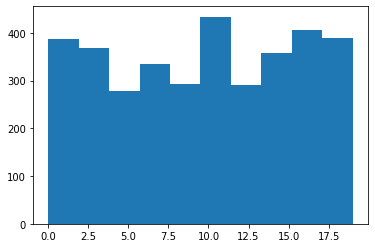

In [14]:
plt.hist(y)

The label Encoder generated in earlier

In [15]:
labelEncoder

{0: 'pins_Miley Cyrus',
 1: 'pins_Emilia Clarke',
 2: 'pins_Rebecca Ferguson',
 3: 'pins_Millie Bobby Brown',
 4: 'pins_grant gustin',
 5: 'pins_Mark Zuckerberg',
 6: 'pins_amber heard',
 7: 'pins_Neil Patrick Harris',
 8: 'pins_Bill Gates',
 9: 'pins_Krysten Ritter',
 10: 'pins_Brenton Thwaites',
 11: 'pins_Alexandra Daddario',
 12: 'pins_Taylor Swift',
 13: 'pins_Stephen Amell',
 14: 'pins_Madelaine Petsch',
 15: 'pins_Jeremy Renner',
 16: 'pins_Katherine Langford',
 17: 'pins_Jennifer Lawrence',
 18: 'pins_Anne Hathaway',
 19: 'pins_Zoe Saldana'}

In [16]:
print(len(knownface))

3540


### The Training , Testing and Validation set is being generated. 


*   The Total dataset is divided into 60%, 20% and 20%
*   60% for Training , 20 % for Testing and 20% for Valudation
*   Here we used a module from Sklearn library to split the dataset.
*   The train_test_split splits module splits the dataset. random_seed ensures that the split is the same upon multiple exevution and the stratify option ensures that the distribution of the target classes of the data is uniform across the splits



In [17]:
X_1, X_test, y_1, y_test = train_test_split( X, y, shuffle=True,random_state = 100,test_size=0.2,stratify=y)

In [18]:
X_train, X_val, y_train, y_val = train_test_split( X_1, y_1,shuffle=True,random_state = 100,test_size=0.25,stratify=y_1)

In [19]:
y_val

array([13,  2, 18, 11, 10,  2, 10, 16, 14, 14, 18, 11,  2,  3, 19, 10,  1,
        9,  6,  2,  5, 19, 17,  6, 11,  7,  1,  8,  3, 11, 16,  0, 18,  9,
        0, 11, 12,  4, 16, 16,  9, 17, 11,  9, 18,  0, 15,  8, 14, 13,  1,
        9,  1,  4,  8, 18, 12, 19,  4, 19, 11, 11, 16, 18,  1, 10,  4, 14,
        3,  1, 16,  5, 16, 17,  4,  4,  3, 10, 14, 14,  3, 11,  7,  3,  9,
       18,  1, 18, 13,  6, 16,  3,  1,  5, 16, 16,  6, 13, 11,  9,  4,  4,
       18,  0, 11, 19, 15, 16, 13, 19,  6, 19, 11,  2, 10, 16, 12,  8,  1,
        3,  0,  0, 13,  0,  6,  9, 17, 14, 11, 16,  8,  6, 10,  2,  9,  1,
       16, 11, 19, 13, 10,  8, 16,  6, 15,  0, 12, 18,  8, 17,  6,  7, 19,
       13, 11,  2, 17, 16, 17,  4,  2, 15, 16,  7, 14,  5,  1, 17, 13,  3,
       15, 16,  1,  9,  0, 18,  9,  6, 16,  4, 18, 11,  0,  8, 18,  3, 15,
       17,  0,  2, 19, 14, 11,  9, 18,  6,  3, 19, 13,  8, 12, 11,  9,  0,
       16,  6, 15,  3,  2,  0, 11,  3,  2,  1, 14,  6,  6,  9,  8,  2, 10,
        2,  5, 15, 13, 15

* **As it can be seen that the distribution has the same shape as that of the original dataset** 

(array([77., 73., 56., 66., 59., 87., 58., 73., 81., 78.]),
 array([ 0. ,  1.9,  3.8,  5.7,  7.6,  9.5, 11.4, 13.3, 15.2, 17.1, 19. ]),
 <a list of 10 Patch objects>)

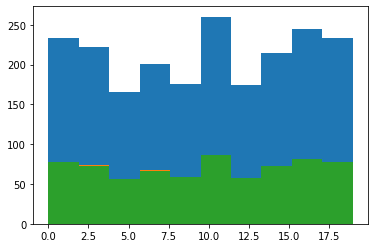

In [20]:
plt.hist(y_train)
plt.hist(y_test)
plt.hist(y_val)

### One Hot Encoding
*   A binary target variable is preffered over a numeric data since using numeric encoding can allow the model to assume a natural ordering between categories may result in poor performance or unexpected results. 

In [21]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)
y_val = tf.keras.utils.to_categorical(y_val, num_classes)

4D Numpy arrays for Train , Test and Validation

In [22]:
print(X_test.shape)
print(X_val.shape)
print(X_train.shape)

(708, 224, 224, 3)
(708, 224, 224, 3)
(2124, 224, 224, 3)


### Image Data Generator
*   Applies certain effect to each of the image in the dataset.
*   This helps in generalisation of the dataset and improves the model performance


### The Effests used here are:
*   rescale: This is applied to all the images. It divied each pixel data but 255 which normalises the data and brings the pixel values in the range of 0 to 1.This helps the model to convege faster

The rest of the effects are random  
*   rotation_range of 10 degrees,
*   Horizontal Flip ,
*   Width Shift in the range of 0.2,
*   Height Shift in the range of 0.1,
*   Zoom in the range of 0.2,
*   Brightness in the range of 0.5 to 1.5 


In [23]:

from keras.preprocessing.image import ImageDataGenerator
'''
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=10,
                                   horizontal_flip=True,
                                   brightness_range = [0.5,1.5],
                                   validation_split=0.2)

training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = IMAGE_SIZE,
                                                 batch_size = 32,
                                                 class_mode = 'categorical', 
                                                 subset='training')

testing_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = IMAGE_SIZE,
                                                 batch_size = 32,
                                                 class_mode = 'categorical', 
                                                 subset='validation')


'''

from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=10,
                                   horizontal_flip=True,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.1,
                                   zoom_range = 0.2,
                                   brightness_range = [0.5,1.5])

training_set = train_datagen.flow(x = X_train,y = y_train,batch_size = 32)

testing_set = train_datagen.flow(x = X_test,y= y_test,batch_size = 32)

validation_set = train_datagen.flow(x= X_val, y = y_val, batch_size=32)



## The Model Defination
*   The Image size needs to 224 x 224 which is the standard size for most CNN models.
*   We are using Transfer Learning to train our model. 
*   Here we are using MobileNet V2 as the base and then subsequently adding more layers to the model.

### Benefits of Tranfer Learning

*    The method of Transfer learning is to leverage the learning from a pre-trained dataset to satisfy our own machine learning needs.
*    The benefit of Transfer Learnig can used if the dataset we have is relatively smaller than the dataset the model was pre-trained on, and the dataset on which it was pre-trained have similar features to the current dataset.
*    Here we are using the the pre-trained weights of the Mobile Net V2 model which was trained on **imagenet** dataset.
*    Though we are un-freezing all the layers, the benefit of pre-trained weights can still be gained as we are starting our traing from a optimised weights values rather than random values.
*    Thus it will help us converge faster

### Benefits of using MobileNet V2 as the base model
Several Image Classification models like VGG16 , InceptioV3 ,ResNet50, and MobileNetV2 were tested on this dataset. Along with that other Image Classification models like LBPH, Caffe Model and many hand crafted CNN models were tested on the dataset. The Mobile Net V2 stood out amongest them and provided thet best performance. 
*     One **major advantage** of using MobileNet_V2 is, the model is lightweight, ie. the weights and model files when saved is around  30 MB, which is significatly smaller than other saved model sizes which were ranging from 100MB to 300 MB 
*     The reason we desisre a model to be lightweight is, the model can support a wide range of hardwares even when the hardware can support less memory.
*     This makes it ideal candidate to be used in Smartphone and and IoT devices for Face Recognition needs.


In [24]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

# add preprocessing layer to the front of VGG
#vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
vgg = MobileNetV2(include_top=False,weights='imagenet', input_shape=(224,224,3))

# don't train existing weights

vgg.trainable=True

# useful for getting number of classes
folders = glob(train_path+'/*')
  
print("Number of classes = ", len(folders))
  

9420800/9406464 [==============================] - 0s 0us/step
Number of classes =  20


In [25]:
vgg.summary()
for l in vgg.layers:
  print(l, l.trainable)

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

### Model Fine tuning
*    3 more layers are added to the Mobile Net V2 achitecture
*    GlobalAveragePooling2D: {Details required}
*    Dropout: This layer is added to decrase overfitting. {Details required.}
*    Dense: The final layer which will provide the probabilities for each of the target classes. {More details required}


In [26]:

x = GlobalAveragePooling2D()(vgg.get_layer('out_relu').output)
x = Dropout(0.8)(x)
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
model.summary()



Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

### Model Checkpoint is used to save the model at certain points in the training process
This helps in two senarios 
*   Since the model is running in a hosted environment, the resouces like CPU, GPU and RAM are shared and can be preemted by the cloud service provider if the resouces are used beyond the limts of Service Level Agreement (SLA).
*   In case of Power outage or Network outage causing a interrupt.

Such interrupts can potentially erase hours of training done during this training process.
Thus we need to save the weights and architecture of the model in some persistant while it is still training.
Model Checkpoint provides such fucntionality to training process.

Here we are saving the model in google drive **after every epoch** if the model achieves a **better accracy over the testing set**.

In [27]:


drive_path_checkpoint = '/content/drive/My Drive/Colab Notebooks/ProjectData/FaceRecognition/pickle/checkpoint/holly_MobileNet_3.h5'
model_checkpoint = ModelCheckpoint(
    filepath=drive_path_checkpoint,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True, save_freq='epoch')





### Model compilation and Specifications
*  Loss
*  Optimizer 
*  Metrics  
We are training the entire network we using a very small aplha value. this hich helps the model to converge 

In [28]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer=tf.keras.optimizers.Adam(1e-4),
  metrics=['accuracy',
           tf.keras.metrics.Precision(),
           tf.keras.metrics.Recall()]
)

Since the traning rate is set to a very low value, the number of epochs are needed to be high enough to reach the accuracy level desired

### Now We train out model

In [29]:
r = model.fit(
  training_set,
  validation_data=testing_set,
  epochs=64,
  callbacks = [model_checkpoint]
)

Epoch 1/64
67/67 [==============================] - 88s 535ms/step - loss: 3.9871 - accuracy: 0.0613 - precision: 0.0607 - recall: 0.0139 - val_loss: 3.3318 - val_accuracy: 0.0862 - val_precision: 0.0641 - val_recall: 0.0053


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/64
67/67 [==============================] - 32s 480ms/step - loss: 3.0623 - accuracy: 0.0937 - precision: 0.0654 - recall: 0.0042 - val_loss: 3.2760 - val_accuracy: 0.1045 - val_precision: 0.0815 - val_recall: 0.0036
Epoch 3/64
67/67 [==============================] - 32s 478ms/step - loss: 2.7793 - accuracy: 0.1747 - precision: 0.0958 - recall: 0.0039 - val_loss: 3.3324 - val_accuracy: 0.1158 - val_precision: 0.1650 - val_recall: 0.0064
Epoch 4/64
67/67 [==============================] - 32s 479ms/step - loss: 2.4634 - accuracy: 0.2373 - precision: 0.1995 - recall: 0.0083 - val_loss: 3.3569 - val_accuracy: 0.1398 - val_precision: 0.3219 - val_recall: 0.0174
Epoch 5/64
67/67 [==============================] - 32s 479ms/step - loss: 2.2363 - accuracy: 0.3108 - precision: 0.3495 - recall: 0.0220 - val_loss: 3.5849 - val_accuracy: 0.1681 - val_precision: 0.4046 - val_recall: 0.0349
Epoch 6/64
67/67 [==============================] - 32s 481ms/step - loss: 1.9166 - accuracy: 0.3928

### Saving the model in h5 format and saving the weights in pickle format

In [30]:
model_path = '/content/drive/My Drive/Colab Notebooks/ProjectData/FaceRecognition/pickle/transferMobileNet_holly_3_dataset.h5'
model.save(model_path)

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [31]:
model_path = '/content/drive/My Drive/Colab Notebooks/ProjectData/FaceRecognition/pickle/transferMobileNet_holly_3_dataset_test.h5'
tf.keras.models.save_model(model, model_path, overwrite=False, include_optimizer=True, save_format='h5',signatures=None, options=None, save_traces=True)

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [33]:
img_weight = model.weights

In [34]:
outfile = open('/content/drive/My Drive/Colab Notebooks/ProjectData/FaceRecognition/pickle/checkpoint/transferMobileNet_holly_2_dataset.pickle','wb')
pickle.dump(img_weight,outfile)
outfile.close()

*   Snippet to load the saved model

In [ ]:
# If you want to load a model
model2 =  load_model('/content/drive/My Drive/Colab Notebooks/ProjectData/FaceRecognition/pickle/transferMobileNet_holly_2_dataset_test.h5')
model2.load_weights('/content/drive/My Drive/Colab Notebooks/ProjectData/FaceRecognition/pickle/checkpoint/holly_MobileNet_2.hdf5')

## **Analysis of training**

In [35]:
NB_EPOCHS = 64
#np.abs(np.subtract(val_loss_trace,loss_trace))
m = []
for i in range(1,NB_EPOCHS+1):
  m.append(i)

### The graphs for Metrics are plotted for each epoch to analyse how those values changed after each epoch.
The plots are saaved in google drive for furture analysis 

mkdir: cannot create directory ‘/content/drive/My Drive/Colab Notebooks/ProjectData/FaceRecognition/plots/holly_test_train_split(checkpoint_holly_MobileNet_2_test)/’: File exists


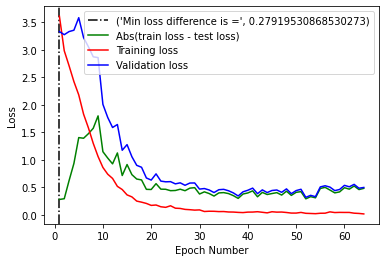

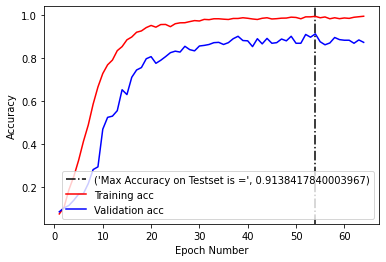

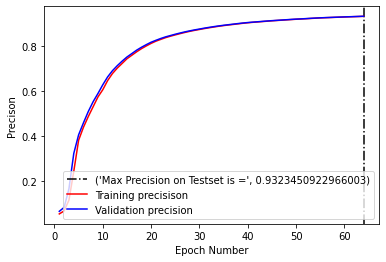

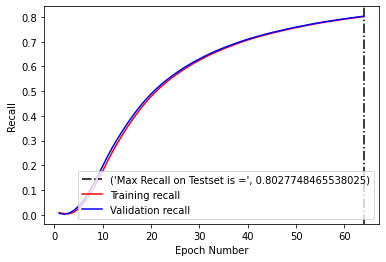

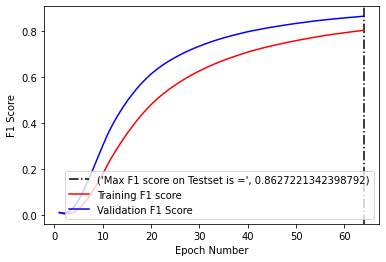

In [36]:
plot_save = '/content/drive/My Drive/Colab Notebooks/ProjectData/FaceRecognition/plots/holly_test_train_split(checkpoint_holly_MobileNet_2_test)/'
!mkdir '{plot_save}'

loss_trace = r.history['loss']
val_loss_trace = r.history['val_loss']
delta = np.abs(np.subtract(val_loss_trace,loss_trace))
min_lo = np.argmin(delta) +1# +1 because the indexing starts from 1
plt.axvline(x=min_lo,c = 'k', linestyle='-.')
s = 'Min loss difference is =',delta[min_lo-1]

plt.plot(m,delta, c = 'g')
plt.plot(m,loss_trace, c='r')
plt.plot(m,val_loss_trace, c='b')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.legend([s,'Abs(train loss - test loss)','Training loss', 'Validation loss'], loc='upper right')
plt.savefig(plot_save+'loss.png')
plt.show()



accuracy_trace = r.history['accuracy']
val_accuracy_trace = r.history['val_accuracy']

max_acc = np.argmax(val_accuracy_trace) +1 # +1 because the indexing starts from 1
plt.axvline(x=max_acc,c = 'k', linestyle='-.')
s0 = 'Max Accuracy on Testset is =',val_accuracy_trace[max_acc-1]

plt.plot(m,accuracy_trace, c='r')
plt.plot(m,val_accuracy_trace, c='b')
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.legend([s0,'Training acc', 'Validation acc'], loc='lower right')
plt.savefig(plot_save+'acc.png')
plt.show()


precision_trace = r.history['precision']
val_precision_trace = r.history['val_precision']

max_pre = np.argmax(val_precision_trace) +1 # +1 because the indexing starts from 1
plt.axvline(x=max_pre,c = 'k', linestyle='-.')
s1 = 'Max Precision on Testset is =',val_precision_trace[max_pre-1]

plt.plot(m,precision_trace, c='r')
plt.plot(m,val_precision_trace, c='b')
plt.xlabel('Epoch Number')
plt.ylabel('Precison')
plt.legend([s1,'Training precisison', 'Validation precision'], loc='lower right')
plt.savefig(plot_save+'pre.png')
plt.show()



recall_trace = r.history['recall']
val_recall_trace = r.history['val_recall']


max_recall = np.argmax(val_recall_trace) +1 # +1 because the indexing starts from 1
plt.axvline(x=max_recall,c = 'k', linestyle='-.')
s2 = 'Max Recall on Testset is =',val_recall_trace[max_recall-1]


plt.plot(m,recall_trace, c='r')
plt.plot(m,val_recall_trace, c='b')
plt.xlabel('Epoch Number')
plt.ylabel('Recall')
plt.legend([s2,'Training recall', 'Validation recall'], loc='lower right')
plt.savefig(plot_save+'recall.png')
plt.show()


f1_score = 2*(np.multiply(precision_trace , recall_trace))/(np.add(precision_trace ,recall_trace))
val_f1_score = 2*(np.multiply(val_precision_trace , val_recall_trace))/(np.add(val_precision_trace ,val_recall_trace))

f1_trace = f1_score
val_recall_trace = val_f1_score

max_f1 = np.argmax(val_f1_score) +1 # +1 because the indexing starts from 1
plt.axvline(x=max_f1,c = 'k', linestyle='-.')
s3 = 'Max F1 score on Testset is =',val_f1_score[max_f1-1]

plt.plot(m,recall_trace, c='r')
plt.plot(m,val_recall_trace, c='b')
plt.xlabel('Epoch Number')
plt.ylabel('F1 Score')
plt.legend([s3, 'Training F1 score', 'Validation F1 Score'], loc='lower right')
plt.savefig(plot_save+'f1.png')
plt.show()


## Model Evaluation

### Evaluating using Augmented validation set

In [37]:
preds = model.evaluate(validation_set)

23/23 [==============================] - 7s 319ms/step - loss: 0.5135 - accuracy: 0.8573 - precision: 0.9321 - recall: 0.8030


In [38]:
test_loss,test_accuracy, test_precision, test_recall = preds
print("Test Loss = ", test_loss)
print("Test Accuracy", test_accuracy)
print("Test Precision", test_precision)
print("Test Recall", test_recall)

Test Loss =  0.513481855392456
Test Accuracy 0.8573446273803711
Test Precision 0.9321323037147522
Test Recall 0.8029661774635315


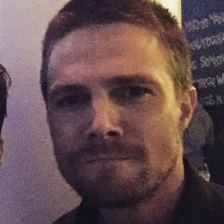

In [39]:
cv2_imshow(X_val[0])
xx = X_val[0].astype(np.float32)
xx /= 255.0

### Evaluating the model using Original Validation images, instead of the augmented images

In [40]:
x_val = X_val.astype(np.float32)/255.0
ev  = model.evaluate(x=x_val, y= y_val)

23/23 [==============================] - 4s 33ms/step - loss: 0.4657 - accuracy: 0.8884 - precision: 0.9320 - recall: 0.8032


In [45]:
test_loss,test_accuracy, test_precision, test_recall = ev
print("Test Loss on Original Dataset= ", test_loss)
print("Test Accuracy on Original Dataset", test_accuracy)
print("Test Precisionon Original Dataset", test_precision)
print("Test Recall on Original Dataset", test_recall)

Test Loss on Original Dataset=  0.4656795263290405
Test Accuracy on Original Dataset 0.8884180784225464
Test Precisionon Original Dataset 0.9319777488708496
Test Recall on Original Dataset 0.80320143699646


### Converting On-Hot encoded target to categorial targets to be used for Face Recognition demonstration

In [41]:
y_cat = np.argmax(y_val, axis=1)

In [42]:
y_cat

array([13,  2, 18, 11, 10,  2, 10, 16, 14, 14, 18, 11,  2,  3, 19, 10,  1,
        9,  6,  2,  5, 19, 17,  6, 11,  7,  1,  8,  3, 11, 16,  0, 18,  9,
        0, 11, 12,  4, 16, 16,  9, 17, 11,  9, 18,  0, 15,  8, 14, 13,  1,
        9,  1,  4,  8, 18, 12, 19,  4, 19, 11, 11, 16, 18,  1, 10,  4, 14,
        3,  1, 16,  5, 16, 17,  4,  4,  3, 10, 14, 14,  3, 11,  7,  3,  9,
       18,  1, 18, 13,  6, 16,  3,  1,  5, 16, 16,  6, 13, 11,  9,  4,  4,
       18,  0, 11, 19, 15, 16, 13, 19,  6, 19, 11,  2, 10, 16, 12,  8,  1,
        3,  0,  0, 13,  0,  6,  9, 17, 14, 11, 16,  8,  6, 10,  2,  9,  1,
       16, 11, 19, 13, 10,  8, 16,  6, 15,  0, 12, 18,  8, 17,  6,  7, 19,
       13, 11,  2, 17, 16, 17,  4,  2, 15, 16,  7, 14,  5,  1, 17, 13,  3,
       15, 16,  1,  9,  0, 18,  9,  6, 16,  4, 18, 11,  0,  8, 18,  3, 15,
       17,  0,  2, 19, 14, 11,  9, 18,  6,  3, 19, 13,  8, 12, 11,  9,  0,
       16,  6, 15,  3,  2,  0, 11,  3,  2,  1, 14,  6,  6,  9,  8,  2, 10,
        2,  5, 15, 13, 15

In [ ]:
#@title Code to upload validation data to drive to tested with other models in future
file1 = open('/content/drive/My Drive/Colab Notebooks/ProjectData/FaceRecognition/pickle/val.pickle','wb')
pickle.dump(zip(X_val,y_cat),file1)
file1.close()

### Evaluating the model for each validation set data point and showing the predictions

In [43]:
count = 0
for img,actual in zip(X_val, y_cat):
    img1 = img
    img = img.astype(np.float32) / 255.0
    np_img = img[np.newaxis,:, :,:]
    preds = model.predict(np_img)
    out = np.argmax(preds)
    name = labelEncoder.get(out)
    if actual == out:
      count += 1
    cv2_imshow(img1)
    print('Actual = ', labelEncoder.get(actual)[5:], ' **** Predicted = ', name[5:])
    print('-------------------------------------------------------------------\n\n\n')

Output hidden; open in https://colab.research.google.com to view.

In [44]:
print("Out of Sample Accuracy = ", count/len(y_cat))

Out of Sample Accuracy =  0.8884180790960452


# THANK YOU

# Jupyter Notebook Bash code for PDF Generation

In [ ]:
path = '/content/drive/My Drive/Colab Notebooks/ProjectData/FaceRecognition/faceMobileNet_TransferLearning.ipynb'

In [ ]:
!pip install -U notebook-as-pdf
!pyppeteer-install

     |████████████████████████████████| 81kB 5.6MB/s 
     |████████████████████████████████| 92kB 7.8MB/s 
     |████████████████████████████████| 143kB 41.7MB/s 
     |████████████████████████████████| 81kB 10.1MB/s 
     |████████████████████████████████| 81kB 11.1MB/s 
  Created wheel for PyPDF2: filename=PyPDF2-1.26.0-cp37-none-any.whl size=61085 sha256=eb279614e1e923f24be282d3668774c2e2557e12ea9f3417453b071fab2b6db5
  Stored in directory: /root/.cache/pip/wheels/53/84/19/35bc977c8bf5f0c23a8a011aa958acd4da4bbd7a229315c1b7
Successfully built PyPDF2
ERROR: requests 2.23.0 has requirement urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you'll have urllib3 1.26.5 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Found existing installation: importlib-metadata 4.0.1
    Uninstalling 

[W:pyppeteer.chromium_downloader] start chromium download.
Download may take a few minutes.
100% 108773488/108773488 [00:00<00:00, 166708898.78it/s]
[W:pyppeteer.chromium_downloader] 
chromium download done.
[W:pyppeteer.chromium_downloader] chromium extracted to: /root/.local/share/pyppeteer/local-chromium/588429


In [ ]:
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-generic-recommended

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono fonts-texgyre
  javascript-common libcupsfilters1 libcupsimage2 libgs9 libgs9-common
  libijs-0.35 libjbig2dec0 libjs-jquery libkpathsea6 libpotrace0 libptexenc1
  libruby2.5 libsynctex1 libtexlua52 libtexluajit2 libzzip-0-13 lmodern
  poppler-data preview-latex-style rake ruby ruby-did-you-mean ruby-minitest
  ruby-net-telnet ruby-power-assert ruby-test-unit ruby2.5
  rubygems-integration t1utils tex-common tex-gyre texlive-base
  texlive-binaries texlive-latex-base texlive-latex-extra
  texlive-latex-recommended texlive-pictures texlive-plain-generic tipa
Suggested packages:
  fonts-noto apache2 | lighttpd | httpd poppler-utils ghostscri

In [ ]:
!jupyter-nbconvert --to pdf '/content/drive/My Drive/Colab Notebooks/ProjectData/FaceRecognition/faceMobileNet_TransferLearning.ipynb'

[NbConvertApp] Converting notebook /content/drive/My Drive/Colab Notebooks/ProjectData/FaceRecognition/faceMobileNet_TransferLearning.ipynb to pdf
/usr/local/lib/python2.7/dist-packages/nbconvert/filters/datatypefilter.py:41: UserWarning: Your element with mimetype(s) [u'application/vnd.colab-display-data+json'] is not able to be represented.
  mimetypes=output.keys())
[NbConvertApp] Support files will be in faceMobileNet_TransferLearning_files/
[NbConvertApp] Making directory ./faceMobileNet_TransferLearning_files
[NbConvertApp] Making directory ./faceMobileNet_TransferLearning_files
[NbConvertApp] Making directory ./faceMobileNet_TransferLearning_files
[NbConvertApp] Making directory ./faceMobileNet_TransferLearning_files
[NbConvertApp] Making directory ./faceMobileNet_TransferLearning_files
[NbConvertApp] Making directory ./faceMobileNet_TransferLearning_files
[NbConvertApp] Making directory ./faceMobileNet_TransferLearning_files
[NbConvertApp] Making directory ./faceMobileNet_Trans